In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

2024-04-01 22:42:33.683228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 22:42:33.683322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 22:42:33.831766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Data Path
training_path = '../input/melanoma/DermMel/train_sep' 
validation_path = '../input/melanoma/DermMel/valid'
test_path = '../input/melanoma/DermMel/test'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
def process_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  
    return img

def process_path(file_path, *args):
    label = tf.strings.split(file_path, '/')[-2]  
    label = tf.equal(label, tf.constant(['Melanoma', 'NotMelanoma']))  
    label = tf.cast(label, tf.int32)  
    img = process_image(file_path)
    return img, label


In [9]:
train_dataset = tf.data.Dataset.list_files(training_path + '/*/*', shuffle=True)
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

val_dataset = tf.data.Dataset.list_files(validation_path + '/*/*', shuffle=False)
val_dataset = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

test_dataset = tf.data.Dataset.list_files(test_path + '/*/*', shuffle=False)
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

### ResNet Implementation

In [11]:
def residual_block(inputs, num_filters, kernel_size=3, strides=1, activation='relu'):
    """
    Residual block
    """
    x = layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    if activation is not None:
        x = layers.Activation(activation)(x)
    
    x = layers.Conv2D(num_filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or inputs.shape[-1] != num_filters:
        inputs = layers.Conv2D(num_filters, 1, strides=strides, padding='same')(inputs)
        
    x = layers.add([x, inputs])
    if activation is not None:
        x = layers.Activation(activation)(x)

    return x

def resnet(input_shape, num_classes, num_blocks, num_filters=64, activation='relu'):
    """
    ResNet implementation
    """
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(num_filters, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    if activation is not None:
        x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for i in range(num_blocks):
        num_filters *= 2
        x = residual_block(x, num_filters, strides=2 if i == 0 else 1, activation=activation)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = resnet(input_shape=(224,224,3), num_classes=2, num_blocks=2)

In [13]:
## tell the model what cost and optimization method to use
model.compile(AdamW(learning_rate = 1e-5), loss='categorical_crossentropy', metrics = ['accuracy'])

## Early callback to avoid overfitting
callbacks = [
        ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.2, 
        patience = 10, 
        verbose = 1,
        mode = 'min', 
        min_lr = 0.00001),
        ]

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │    147,584 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    295,168 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    590,080 │ activation_3[0][

 Total params: 1,161,346 (4.43 MB)

 Trainable params: 1,159,682 (4.42 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 10,
                    callbacks = callbacks)

Epoch 1/10
  3/334 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.5156 - loss: 0.7824   

I0000 00:00:1712011582.433728      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7629 - loss: 0.4952

W0000 00:00:1712011619.890400      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.7631 - loss: 0.4950 - val_accuracy: 0.7529 - val_loss: 0.5426 - learning_rate: 1.0000e-05
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8542 - loss: 0.3366 - val_accuracy: 0.6317 - val_loss: 1.1881 - learning_rate: 1.0000e-05
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8873 - loss: 0.2747 - val_accuracy: 0.8880 - val_loss: 0.2796 - learning_rate: 1.0000e-05
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9027 - loss: 0.2449 - val_accuracy: 0.9222 - val_loss: 0.2258 - learning_rate: 1.0000e-05
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9066 - loss: 0.2297 - val_accuracy: 0.8456 - val_loss: 0.3937 - learning_rate: 1.0000e-05
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9185 - loss: 0.2085 - val_accuracy: 0.7310 - val_loss: 0.6881 - learning_rate: 1.0000e-05
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accura

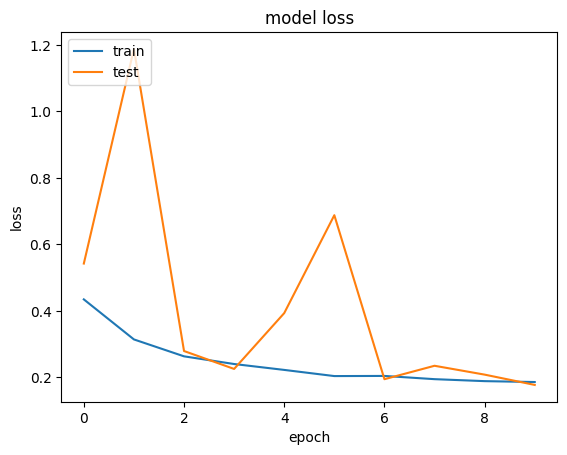

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss.jpg')
plt.show()

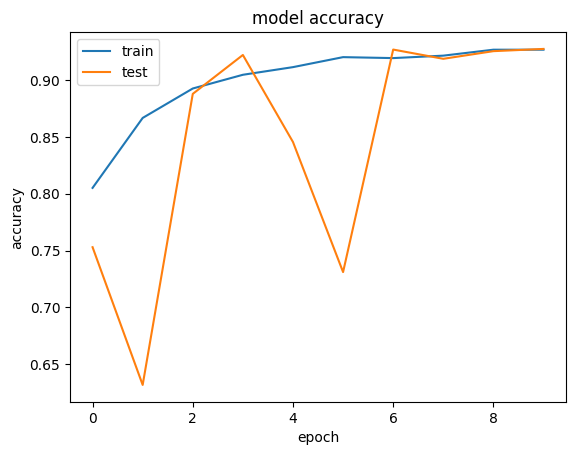

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig('accuracy.jpg')

In [18]:
loss,accuracy = model.evaluate(test_dataset)
print("Loss {}".format(loss))
print("Accuracy {}".format(accuracy))

112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9480 - loss: 0.1125
Loss 0.18219825625419617
Accuracy 0.9199662804603577


### EfficientNetB0 Transfer Learning

In [26]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

In [34]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  
predictions = layers.Dense(2, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "functional_9"

In [36]:
history2 = model2.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 10,
                    callbacks = callbacks)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 66s 119ms/step - accuracy: 0.4997 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5088 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5023 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4997 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4949 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4997 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4983 - 

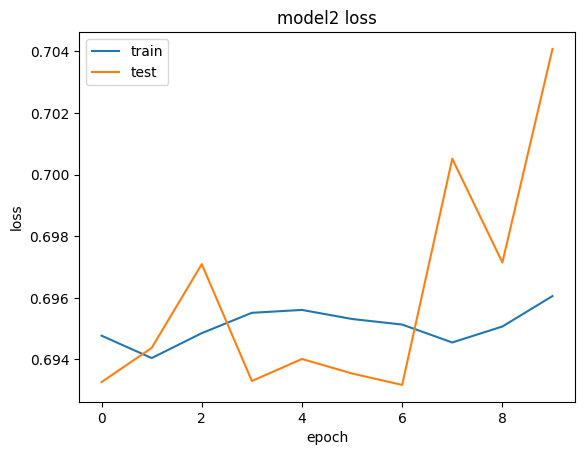

In [37]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss.jpg')
plt.show()

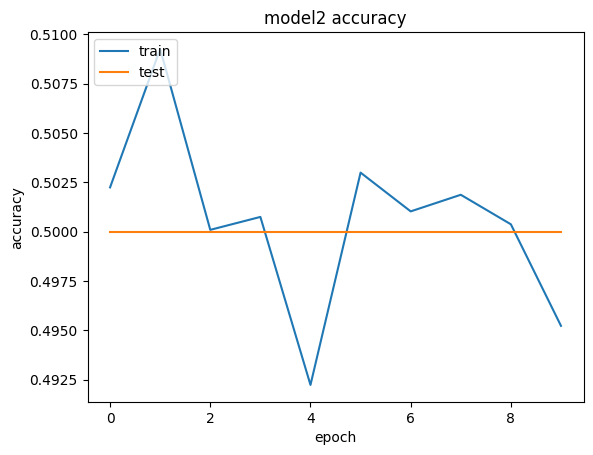

In [38]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.savefig('accuracy.jpg')

In [39]:
loss2,accuracy2 = model2.evaluate(test_dataset)
print("Loss {}".format(loss2))
print("Accuracy {}".format(accuracy2))

112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8392 - loss: 0.6068
Loss 0.7040771842002869
Accuracy 0.5001404285430908


In [40]:
model.save("Custom_residual_cnn.h5")
model2.save("EffNetB0.h5")

### Conclusions

It comes to light that a custom Residual Block-based Convolutional Neural Network with 2 blocks trained from scratch on this dataset works better than using a pre-trained EfficientNetB0 on ImageNet with a classifier layer attached to it.